In [32]:
import napari
import imageio as io
from pathlib import Path
import numpy as np
import h5py

Create dataframe with regionprops features for each timnepoint

In [481]:
from skimage.measure import regionprops_table
import pandas as pd

#extracts regionprops features from the mask area in one frame

def measure_morphology_2D(label_timepoint):
    """
    Measure the morphology features of a 2D label image.
    Parameters:
        label_image: ndarray
            An ndarray in which each object is labelled with a unique value.
        file_id: int or str
            An ID number or string identifier for the file.
        timepoint: int
            The timepoint index for the frame.
    Returns:
        regionprops: pandas.DataFrame
            Pandas DataFrame containing the measured morphology features for
            every object.
    """

    # measure regionprops for each timepoint
    features = ('label', 'area', 'convex_area', 'centroid_local', 'eccentricity', 'equivalent_diameter', 'extent', 
                'moments_central', 'moments_hu', 
                'axis_major_length', 'axis_minor_length', 'perimeter', 'solidity')

    regionprops = pd.DataFrame(
        regionprops_table(label_image=label_timepoint, properties=features))
    
    

    return regionprops


In [482]:
#loops over all the timepoints within a file and appends timepoint and the features for each timepoint to the dataframe

def measure_morphology_2DT(embryo_id, labels):

    regionprops = []
    

    for idx, label_timepoint in enumerate(labels):

        current_regionprops = measure_morphology_2D(label_timepoint)
        current_regionprops['timepoint'] = idx

        regionprops.append(current_regionprops)

    dataframe = pd.concat(regionprops)
    dataframe['embryo ID'] = embryo_id

    return dataframe



In [489]:

#loops over all the files within a folder and creates one big dataset

from skimage.measure import label

fld = Path("Q:\carspi\ETiX-SBR-Cer1_exp2")
fld_out = Path("Q:\carspi\ETiX_Output")

all_dfs=[]

for fn in fld.glob('*.h5'):
    with h5py.File(fn) as f:

        lbl = f['mask_cleanup_corrected/2'][...]
        lbl = label(lbl)
        

        embryo_id= fn.name.split('.')[0]
        embryo_id = embryo_id.split("_")[-1].strip('s')
        embryo_id = int(embryo_id)

        lbl_df=measure_morphology_2DT(embryo_id, lbl)
        all_dfs.append(lbl_df)

final_df = pd.concat(all_dfs, ignore_index=True)
# Assuming 'embryo ID' and 'timepoint' are the first two columns, and the rest are features
column_order = ['embryo ID', 'timepoint'] + [col for col in final_df.columns if col not in ['embryo ID', 'timepoint']]
final_df = final_df[column_order]

# Delete the rows where there is another 'mask'
final_df = final_df[final_df.iloc[:, 2] == 1]

final_df.to_csv( fld_out /'feature_extraction_exp2.csv', index=False)#change to desired output folder


In [490]:
final_df

,embryo ID,timepoint,label,area,convex_area,centroid_local-0,centroid_local-1,eccentricity,equivalent_diameter,extent,...,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,axis_major_length,axis_minor_length,perimeter,solidity
0,10,0,1,11569.0,12696.0,74.745181,66.247040,0.512448,121.367658,0.649579,...,0.000684,0.000837,0.000006,-7.055023e-11,1.454508e-07,3.725913e-10,135.799485,116.613496,476.546248,0.911232
1,10,1,1,10623.0,11547.0,64.671844,63.972795,0.757060,116.299715,0.609711,...,0.005383,0.000676,0.000035,5.169741e-09,2.522180e-06,-1.317830e-09,147.503112,96.370393,452.830519,0.919979
2,10,2,1,11564.0,12974.0,63.072812,68.732618,0.723179,121.341428,0.625250,...,0.004055,0.000666,0.000030,3.812603e-09,1.732913e-06,-1.859184e-09,150.094609,103.664432,484.244733,0.891321
3,10,3,1,12200.0,13253.0,62.357623,72.462131,0.734807,124.633553,0.641160,...,0.004378,0.000470,0.000025,1.803074e-09,1.226808e-06,-2.052112e-09,154.665125,104.905748,470.244733,0.920546
4,10,4,1,12758.0,14081.0,65.380859,72.356482,0.729115,127.451913,0.611015,...,0.004245,0.000623,0.000029,2.165818e-09,1.219824e-06,-3.165045e-09,158.170668,108.250585,498.114790,0.906044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,77,17,1,22400.0,25092.0,96.426875,104.985759,0.686058,168.880330,0.651769,...,0.003119,0.001090,0.000022,-2.444976e-09,-1.227985e-06,2.466529e-09,206.226020,150.039016,706.783838,0.892715
3650,77,18,1,23513.0,26478.0,104.586484,102.265725,0.675556,173.025089,0.640332,...,0.002863,0.001003,0.000018,-2.096388e-09,-9.325544e-07,1.152048e-09,210.023017,154.851769,711.754401,0.888020
3651,77,19,1,24144.0,27105.0,102.072026,106.922341,0.657628,175.331388,0.624069,...,0.002454,0.000932,0.000011,4.784824e-11,-4.558185e-07,1.075169e-09,210.361516,158.474266,698.340187,0.890758
3652,77,20,1,24063.0,26984.0,105.072934,99.897436,0.647841,175.037034,0.648511,...,0.002315,0.001117,0.000020,-3.966854e-10,-8.526157e-07,2.966450e-09,210.087151,160.039304,685.411255,0.891751


Normalize dataframe across features

In [533]:

path=Path(r"Q:\carspi\ETiX_Output\final_df_check.csv")

final_df = pd.read_csv(path)


In [535]:
from scipy.stats import zscore
import pandas as pd

# Copy the first two columns unchanged
zscored_df = final_df.iloc[:, :3].copy()

# Z-score columns 3 to 71
zscored_df[final_df.columns[3:]] = final_df.iloc[:, 3:].apply(zscore)


zscored_df

#zscored_df.to_csv( fld_out /'zscore.csv', index=False)#change to desired output folder


,embryo ID,timepoint,label,area,convex_area,centroid_local-0,centroid_local-1,eccentricity,equivalent_diameter,extent,...,moments_normalized-2-2,moments_normalized-2-3,moments_normalized-3-0,moments_normalized-3-1,moments_normalized-3-2,moments_normalized-3-3,axis_major_length,axis_minor_length,perimeter,solidity
0,10,0,1,-0.672278,-0.679803,-0.669688,-0.495495,-1.229578,-0.634822,0.116547,...,-0.594330,0.063954,0.204475,0.240847,0.009545,0.053267,-0.922656,-0.308128,-0.698472,0.306951
1,10,1,1,-0.342303,-0.405285,-0.139610,-0.392488,-1.461412,-0.256937,0.633346,...,-0.551744,0.035020,0.000797,0.115249,0.072872,0.045683,-0.641878,0.105018,-0.515416,1.014296
2,10,2,1,-0.118262,-0.178309,-0.447341,-0.060712,-1.452191,-0.017529,0.868036,...,-0.477795,0.076354,0.556122,0.115999,-0.095857,0.037167,-0.435201,0.359591,-0.255245,0.776946
3,10,3,1,0.030948,-0.012120,0.075088,0.267782,-1.552178,0.135413,-0.270927,...,-0.722782,0.150271,0.081217,0.173651,0.057070,0.034734,-0.323444,0.528168,-0.094102,0.438914
4,10,4,1,0.051984,-0.023692,-0.076781,0.435442,-0.536029,0.156593,-0.229042,...,-0.640563,0.106715,0.249752,0.447420,0.016068,0.115046,-0.142846,0.352098,-0.130455,0.873331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6803,99,18,1,-0.196699,-0.241327,-0.399750,0.069828,0.484359,-0.099944,0.292374,...,-0.070481,0.151229,-0.070094,0.927513,0.170161,0.303898,-0.068567,-0.215338,-0.290685,0.602480
6804,99,19,1,-0.147263,-0.188208,-0.146002,-0.038420,0.177501,-0.047832,0.082036,...,-0.270898,0.098784,-0.076362,0.838382,0.118535,0.228487,-0.128731,-0.051372,-0.254908,0.514533
6805,99,20,1,-0.093018,-0.159348,-0.385145,0.234831,0.099667,0.008692,0.274560,...,-0.246431,0.139910,-0.113379,0.626199,0.171426,0.194492,-0.106726,0.024466,-0.225270,0.850379
6806,99,21,1,-0.027654,-0.100931,-0.334828,0.277158,0.072912,0.075923,0.593756,...,-0.220982,0.113604,-0.174710,0.625354,0.143214,0.205403,-0.058058,0.094354,-0.159616,0.900278


Create subset of df if needed

In [542]:

timepoint_zscored_df = zscored_df.drop(['embryo ID', 'label'], axis=1)

timepoint_zscored_df

,timepoint,area,convex_area,centroid_local-0,centroid_local-1,eccentricity,equivalent_diameter,extent,moments_central-0-0,moments_central-0-1,...,moments_normalized-2-2,moments_normalized-2-3,moments_normalized-3-0,moments_normalized-3-1,moments_normalized-3-2,moments_normalized-3-3,axis_major_length,axis_minor_length,perimeter,solidity
0,0,-0.672278,-0.679803,-0.669688,-0.495495,-1.229578,-0.634822,0.116547,-0.672278,0.467751,...,-0.594330,0.063954,0.204475,0.240847,0.009545,0.053267,-0.922656,-0.308128,-0.698472,0.306951
1,1,-0.342303,-0.405285,-0.139610,-0.392488,-1.461412,-0.256937,0.633346,-0.342303,-0.377790,...,-0.551744,0.035020,0.000797,0.115249,0.072872,0.045683,-0.641878,0.105018,-0.515416,1.014296
2,2,-0.118262,-0.178309,-0.447341,-0.060712,-1.452191,-0.017529,0.868036,-0.118262,-0.767458,...,-0.477795,0.076354,0.556122,0.115999,-0.095857,0.037167,-0.435201,0.359591,-0.255245,0.776946
3,3,0.030948,-0.012120,0.075088,0.267782,-1.552178,0.135413,-0.270927,0.030948,0.139398,...,-0.722782,0.150271,0.081217,0.173651,0.057070,0.034734,-0.323444,0.528168,-0.094102,0.438914
4,4,0.051984,-0.023692,-0.076781,0.435442,-0.536029,0.156593,-0.229042,0.051984,-0.377790,...,-0.640563,0.106715,0.249752,0.447420,0.016068,0.115046,-0.142846,0.352098,-0.130455,0.873331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6803,18,-0.196699,-0.241327,-0.399750,0.069828,0.484359,-0.099944,0.292374,-0.196699,-0.248493,...,-0.070481,0.151229,-0.070094,0.927513,0.170161,0.303898,-0.068567,-0.215338,-0.290685,0.602480
6804,19,-0.147263,-0.188208,-0.146002,-0.038420,0.177501,-0.047832,0.082036,-0.147263,0.010101,...,-0.270898,0.098784,-0.076362,0.838382,0.118535,0.228487,-0.128731,-0.051372,-0.254908,0.514533
6805,20,-0.093018,-0.159348,-0.385145,0.234831,0.099667,0.008692,0.274560,-0.093018,0.010101,...,-0.246431,0.139910,-0.113379,0.626199,0.171426,0.194492,-0.106726,0.024466,-0.225270,0.850379
6806,21,-0.027654,-0.100931,-0.334828,0.277158,0.072912,0.075923,0.593756,-0.027654,0.010101,...,-0.220982,0.113604,-0.174710,0.625354,0.143214,0.205403,-0.058058,0.094354,-0.159616,0.900278


In [537]:

no_timepoint_zscored_df = timepoint_zscored_df.drop('timepoint', axis=1)

print(no_timepoint_zscored_df)

          area  convex_area  centroid_local-0  centroid_local-1  eccentricity  \
0    -0.672278    -0.679803         -0.669688         -0.495495     -1.229578   
1    -0.342303    -0.405285         -0.139610         -0.392488     -1.461412   
2    -0.118262    -0.178309         -0.447341         -0.060712     -1.452191   
3     0.030948    -0.012120          0.075088          0.267782     -1.552178   
4     0.051984    -0.023692         -0.076781          0.435442     -0.536029   
...        ...          ...               ...               ...           ...   
6803 -0.196699    -0.241327         -0.399750          0.069828      0.484359   
6804 -0.147263    -0.188208         -0.146002         -0.038420      0.177501   
6805 -0.093018    -0.159348         -0.385145          0.234831      0.099667   
6806 -0.027654    -0.100931         -0.334828          0.277158      0.072912   
6807  0.055591     0.008096         -0.189824          0.091905     -0.271431   

      equivalent_diameter  

Create UMAP on subset of 'raw' features dataframe

c:\Users\carspi\AppData\Local\miniconda3\envs\abbott\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



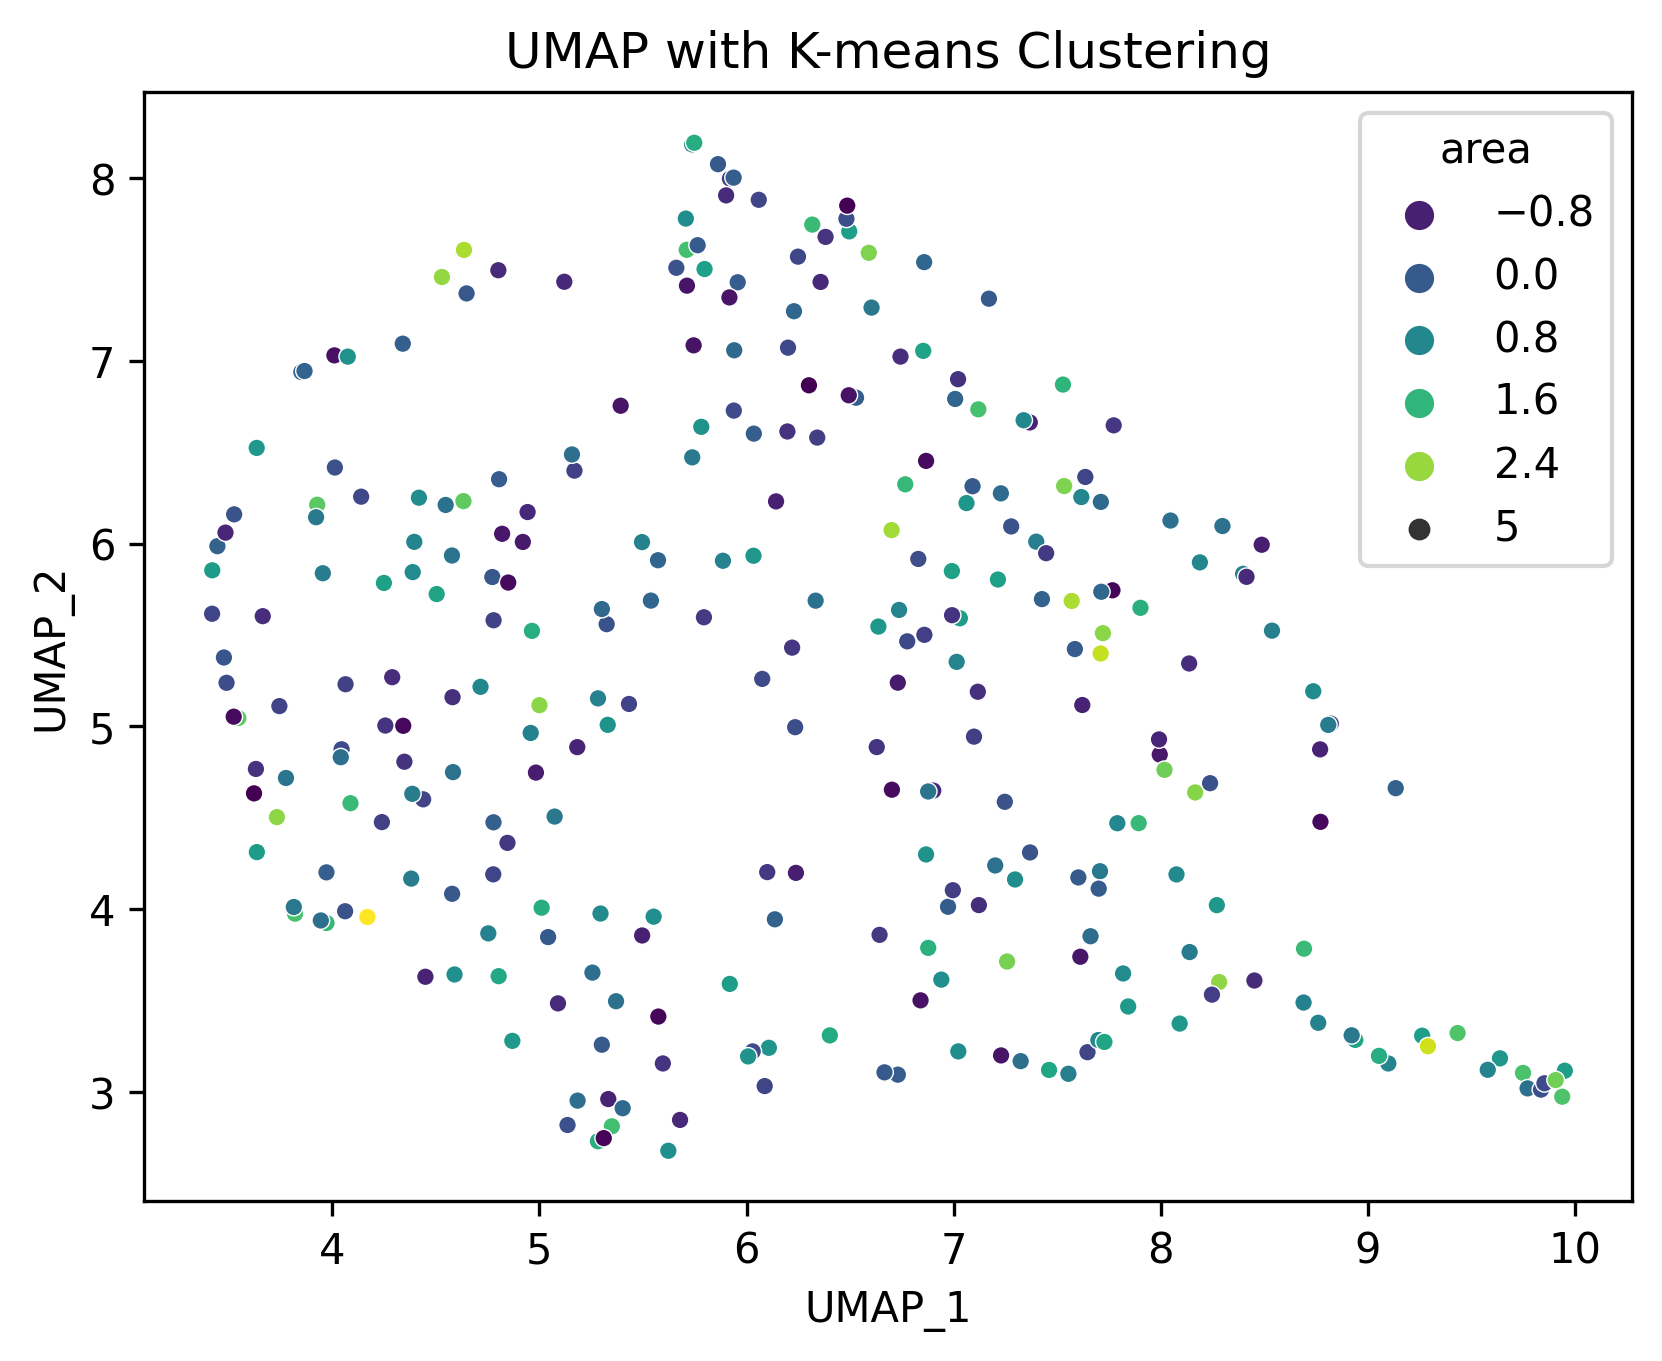

In [541]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap

subset_df = timepoint_zscored_df[timepoint_zscored_df['timepoint'] ==22] #select timepoint you want to plot, or alternatively skip this line to plot all timepoints, and visualize the timepoints
subset_df = subset_df.drop('timepoint', axis=1)

# UMAP transformation
umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(subset_df)

# K-means clustering
kmeans = KMeans(n_clusters=10)  # You can adjust the number of clusters as needed
kmeans_labels = kmeans.fit_predict(subset_df)

# Add UMAP and K-means labels to the DataFrame
UMAP_df = pd.DataFrame()

UMAP_df['UMAP_1'] = umap_result[:, 0]
UMAP_df['UMAP_2'] = umap_result[:, 1]
UMAP_df['KMeans_Labels'] = kmeans_labels

UMAP_df['area'] = timepoint_zscored_df['area'] #add zscore feature you want to visualize from timepoint_zscored_df

# Visualize UMAP and K-means clusters if needed
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax=plt.subplots(dpi=300)

sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='area', data=UMAP_df, palette='viridis', size=5)
plt.title('UMAP with K-means Clustering')
plt.show()


Choose amount of clusters: elbow plot, gap statistics

c:\Users\carspi\AppData\Local\miniconda3\envs\abbott\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\carspi\AppData\Local\miniconda3\envs\abbott\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\carspi\AppData\Local\miniconda3\envs\abbott\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\carspi\AppData\Local\miniconda3\envs\abbott\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\U

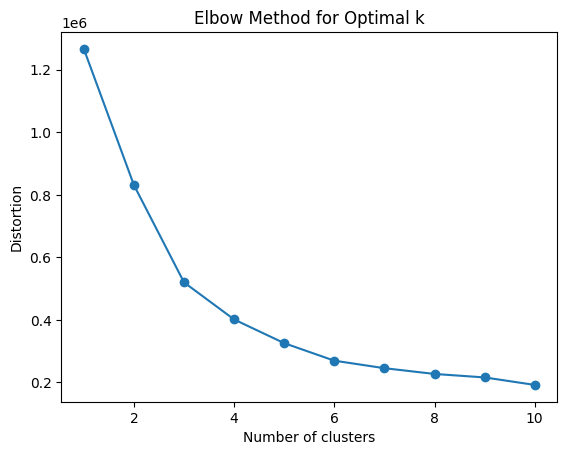

In [411]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming umap_result is the UMAP-transformed data
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(subset_df)
    distortions.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), distortions, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()


In [540]:
from gap_statistic import OptimalK

optimal_k = OptimalK(parallel_backend='joblib')
k_clusters = optimal_k(subset_df, cluster_array=np.arange(1, 11))

k_clusters

10

Compute PCA on zscored df


In [543]:
timepoint_zscored_df

,timepoint,area,convex_area,centroid_local-0,centroid_local-1,eccentricity,equivalent_diameter,extent,moments_central-0-0,moments_central-0-1,...,moments_normalized-2-2,moments_normalized-2-3,moments_normalized-3-0,moments_normalized-3-1,moments_normalized-3-2,moments_normalized-3-3,axis_major_length,axis_minor_length,perimeter,solidity
0,0,-0.672278,-0.679803,-0.669688,-0.495495,-1.229578,-0.634822,0.116547,-0.672278,0.467751,...,-0.594330,0.063954,0.204475,0.240847,0.009545,0.053267,-0.922656,-0.308128,-0.698472,0.306951
1,1,-0.342303,-0.405285,-0.139610,-0.392488,-1.461412,-0.256937,0.633346,-0.342303,-0.377790,...,-0.551744,0.035020,0.000797,0.115249,0.072872,0.045683,-0.641878,0.105018,-0.515416,1.014296
2,2,-0.118262,-0.178309,-0.447341,-0.060712,-1.452191,-0.017529,0.868036,-0.118262,-0.767458,...,-0.477795,0.076354,0.556122,0.115999,-0.095857,0.037167,-0.435201,0.359591,-0.255245,0.776946
3,3,0.030948,-0.012120,0.075088,0.267782,-1.552178,0.135413,-0.270927,0.030948,0.139398,...,-0.722782,0.150271,0.081217,0.173651,0.057070,0.034734,-0.323444,0.528168,-0.094102,0.438914
4,4,0.051984,-0.023692,-0.076781,0.435442,-0.536029,0.156593,-0.229042,0.051984,-0.377790,...,-0.640563,0.106715,0.249752,0.447420,0.016068,0.115046,-0.142846,0.352098,-0.130455,0.873331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6803,18,-0.196699,-0.241327,-0.399750,0.069828,0.484359,-0.099944,0.292374,-0.196699,-0.248493,...,-0.070481,0.151229,-0.070094,0.927513,0.170161,0.303898,-0.068567,-0.215338,-0.290685,0.602480
6804,19,-0.147263,-0.188208,-0.146002,-0.038420,0.177501,-0.047832,0.082036,-0.147263,0.010101,...,-0.270898,0.098784,-0.076362,0.838382,0.118535,0.228487,-0.128731,-0.051372,-0.254908,0.514533
6805,20,-0.093018,-0.159348,-0.385145,0.234831,0.099667,0.008692,0.274560,-0.093018,0.010101,...,-0.246431,0.139910,-0.113379,0.626199,0.171426,0.194492,-0.106726,0.024466,-0.225270,0.850379
6806,21,-0.027654,-0.100931,-0.334828,0.277158,0.072912,0.075923,0.593756,-0.027654,0.010101,...,-0.220982,0.113604,-0.174710,0.625354,0.143214,0.205403,-0.058058,0.094354,-0.159616,0.900278


Loadings (Coefficients):
                          PC1       PC2       PC3       PC4       PC5  \
centroid_local-0    -0.021285 -0.053361  0.103687  0.165499  0.044404   
centroid_local-1    -0.018233 -0.066446  0.113858  0.106253  0.113671   
eccentricity        -0.006474 -0.001894  0.024083  0.078346 -0.034385   
equivalent_diameter -0.021936 -0.069943  0.127803  0.157330  0.112896   
extent               0.002717 -0.007203 -0.016811 -0.037746  0.040686   
moments_central-0-0 -0.028883 -0.072755  0.143857  0.185991  0.142374   
moments_central-0-1  0.003330 -0.004503 -0.027235  0.106064 -0.112805   
moments_central-0-2 -0.039287 -0.066554  0.171704  0.236372  0.167887   
moments_central-0-3 -0.003944  0.043494 -0.005556  0.331463 -0.405970   
moments_central-1-0  0.000153 -0.053585 -0.064612 -0.169968 -0.025938   
moments_central-1-1 -0.000304  0.091006  0.388334 -0.147736 -0.178406   
moments_central-1-2 -0.002595  0.002046 -0.072080  0.126357 -0.311389   
moments_central-1-3  0.005

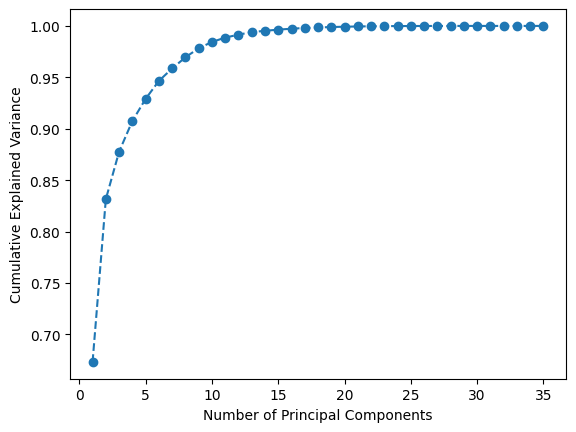

In [315]:
from sklearn.decomposition import PCA

# timepoint selection
subset_df = timepoint_zscored_df[timepoint_zscored_df['timepoint'] ==22]

# Select relevant columns for PCA (excluding embryo ID, timepoint and constant columns)
columns_for_pca = timepoint_zscored_df.columns[0:]

# Create a PCA instance
pca = PCA()

# Fit and transform the data
pca_result = pca.fit_transform(timepoint_zscored_df[columns_for_pca])

# Create a DataFrame to store the results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(len(columns_for_pca))])

# Get the loadings (coefficients) for each variable in each principal component
loadings_df = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(columns_for_pca))], index=columns_for_pca)

# Display the loadings
print("Loadings (Coefficients):")
print(loadings_df)

# Print the explained variance ratio for each principal component
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

# Plotting the explained variance
import matplotlib.pyplot as plt

plt.plot(range(1, len(columns_for_pca) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

<Axes: >

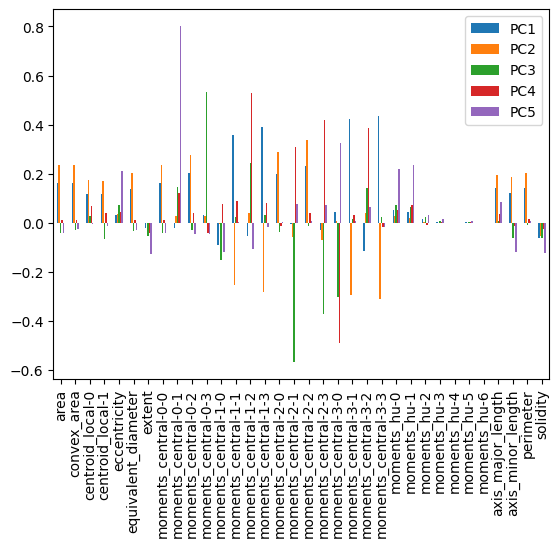

In [170]:
loadings_df.iloc[:, :5].plot.bar()

UMAP on PCs

In [544]:
# Add zscored feature you want to visualize to the PCA dataframe
pca_feature_hue_df = pca_df.merge(timepoint_zscored_df[['area']], left_index=True, right_index=True, how='left')


In [545]:
pca_feature_hue_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC30,PC31,PC32,PC33,PC34,PC35,UMAP_1,UMAP_2,KMeans_Labels,area
0,-10.487149,-5.226509,-1.112185,0.876952,2.485867,-0.757917,1.285647,-2.573745,1.511445,-2.214658,...,-0.032051,0.015132,0.008258,0.000914,-0.001279,-0.000053,8.124929,-15.484546,1,-0.672278
1,-9.920029,-9.291936,-12.024563,9.238345,4.568296,3.953337,5.295908,0.622985,0.121394,-0.382933,...,0.002299,0.014968,0.015477,-0.001136,0.004874,-0.000437,8.184938,-16.646624,1,-0.342303
2,-10.566898,-5.556084,-1.393698,3.274582,1.186084,0.186536,2.752655,3.363597,0.380628,-1.778898,...,0.012984,0.001539,-0.003462,0.000789,0.001565,0.000068,7.608419,-16.297266,1,-0.118262
3,16.701020,-0.426016,-0.167382,-0.389940,-0.787229,-0.066161,-0.638054,0.768305,-0.197913,-0.176899,...,0.003681,-0.009530,0.006283,-0.001504,0.001283,-0.000061,4.507752,8.077987,0,0.030948
4,-9.929279,-6.124176,-4.045230,3.997189,-1.584759,0.429390,1.124535,0.865227,4.231343,1.605343,...,-0.044442,0.014264,0.000519,0.001931,0.003725,0.000200,7.579141,-16.673964,1,0.051984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,-14.130453,14.326103,-4.526524,-2.275126,0.202371,-0.455257,-1.598394,0.297886,1.353156,-1.418700,...,-0.013105,0.002095,-0.002956,-0.000821,-0.009069,0.000018,-1.371250,12.449165,5,0.506977
292,3.340960,17.764259,11.378744,-1.952457,12.993886,1.432731,5.041397,-6.874277,0.467899,3.369718,...,0.013803,0.005474,-0.001191,-0.005083,-0.007419,0.000799,0.849821,12.658986,8,0.546646
293,17.179954,-0.517847,-1.496983,-2.043018,-1.226269,-0.685132,-0.154756,1.085211,0.248591,-0.918156,...,0.003248,-0.022374,-0.006212,0.000274,-0.003178,0.000011,-5.143841,-16.417316,4,0.677975
294,-12.296639,-2.944464,4.266253,-1.555090,-2.697579,-2.648678,1.028024,-3.316114,0.944491,2.488916,...,-0.026347,-0.009593,0.001666,0.002963,0.004436,-0.000241,-6.748497,-1.389077,3,0.912233


c:\Users\carspi\AppData\Local\miniconda3\envs\abbott\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

c:\Users\carspi\AppData\Local\miniconda3\envs\abbott\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



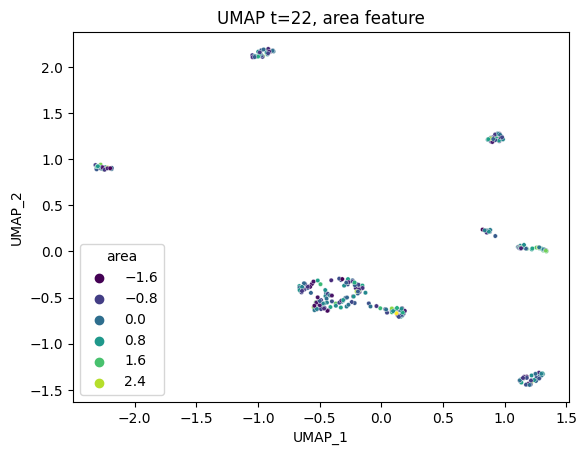

In [343]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap


# pca_df run on zscored data, no need for additional Z-score standardization
#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(pca_df)

# UMAP transformation
umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(pca_df)

# K-means clustering
kmeans = KMeans(n_clusters=9)  # You can adjust the number of clusters as needed
kmeans_labels = kmeans.fit_predict(umap_result)

# Add UMAP and K-means labels to the DataFrame
pca_UMAP_df = pd.DataFrame()


pca_UMAP_df['UMAP_1'] = umap_result[:, 0]
pca_UMAP_df['UMAP_2'] = umap_result[:, 1]
pca_UMAP_df['KMeans_Labels'] = kmeans_labels

pca_UMAP_df['area'] = timepoint_zscored_df['area'] #pick feature you want to visualize across PCs
pca_df.merge(timepoint_zscored_df[['area']], left_index=True, right_index=True, how='left')

# Visualize UMAP and K-means clusters if needed
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='area', data=pca_feature_hue_df, palette='viridis', marker='o', s=10, edgecolor='w')
plt.title('UMAP t=22, area feature')
plt.show()


In [344]:
from gap_statistic import OptimalK

optimal_k = OptimalK(parallel_backend='joblib')
k_clusters = optimal_k(umap_result, cluster_array=np.arange(1, 11))

k_clusters


9

c:\Users\carspi\AppData\Local\miniconda3\envs\abbott\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\carspi\AppData\Local\miniconda3\envs\abbott\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\carspi\AppData\Local\miniconda3\envs\abbott\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\carspi\AppData\Local\miniconda3\envs\abbott\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\U

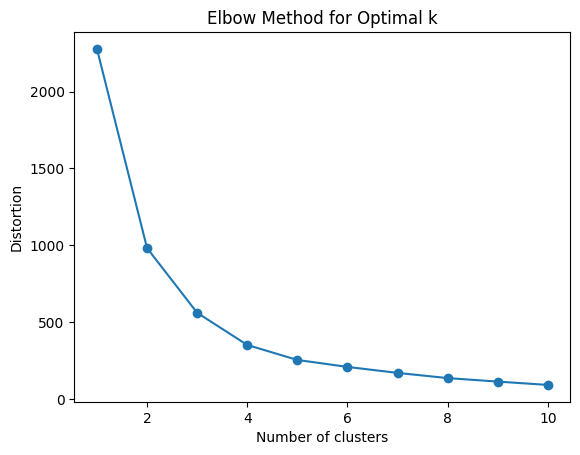

In [178]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming umap_result is the UMAP-transformed data
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(umap_result)
    distortions.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), distortions, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()


In [199]:
#identify the plotted embryos 

import pandas as pd

# Assuming pca_df and final_df are your DataFrames
# Create a subset DataFrame where timepoint is 22
subset_final_df = final_df[final_df['timepoint'] == 0]

# Ensure the indices match
pca_df = pca_df.set_index(subset_final_df.index)

# Concatenate along the columns
combined_df = pd.concat([subset_final_df, pca_df], axis=1)


In [200]:
combined_df

,embryo ID,timepoint,label,area,convex_area,centroid_local-0,centroid_local-1,eccentricity,equivalent_diameter,extent,...,PC28,PC29,PC30,PC31,PC32,PC33,PC34,UMAP_1,UMAP_2,KMeans_Labels
0,10,0,1,11437.0,11874.0,60.387514,63.937221,0.364768,120.673281,0.732015,...,-0.012330,-0.003222,-0.000876,0.002618,-0.002590,0.000162,3.692830e-14,3.527115,7.058797,2
26,101,0,1,9840.0,10549.0,52.639634,54.105793,0.710792,111.931573,0.683523,...,-0.017905,-0.009834,-0.004645,-0.002681,0.001912,0.000785,4.620195e-17,6.623588,11.604994,0
50,105,0,1,10803.0,11290.0,58.063408,75.069425,0.549961,117.280888,0.662679,...,-0.027911,0.004234,0.001530,0.003586,0.002903,0.000662,-1.125624e-15,4.681713,8.267855,2
73,106,0,1,8066.0,8284.0,60.674188,46.050459,0.667755,101.340763,0.742999,...,-0.007309,0.000860,0.003685,-0.000725,-0.001579,-0.000815,1.560168e-16,5.911744,11.556799,0
96,107,0,1,10484.0,10688.0,57.923407,54.145269,0.423984,115.536329,0.772814,...,-0.004909,-0.004462,-0.000630,-0.000915,0.001238,0.001859,4.610539e-17,4.254638,10.974458,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,95,0,1,6628.0,7363.0,64.671998,43.058992,0.694201,91.864203,0.624458,...,-0.019556,-0.002194,-0.003149,-0.011758,0.016336,-0.000681,-2.641792e-16,3.088222,7.962780,2
6900,96,0,1,9857.0,10760.0,51.526631,59.178756,0.751740,112.028221,0.668634,...,-0.010806,-0.010666,0.002474,0.002873,-0.000725,0.001516,1.384207e-16,6.734544,11.498428,0
6926,97,0,1,6601.0,6763.0,44.884866,46.320557,0.273136,91.676901,0.788462,...,0.002621,-0.003321,0.001514,-0.001120,0.000609,-0.002085,-5.303549e-16,0.931782,12.123125,1
6949,98,0,1,9684.0,10514.0,60.667493,65.103986,0.812825,111.040766,0.611866,...,-0.000839,-0.021505,0.001534,0.005514,0.000312,0.002727,-1.257490e-15,6.960994,8.088610,0


dynamic UMAP with embryo ID

In [189]:
import plotly.express as px
from sklearn.cluster import KMeans

# Assuming combined_df is your DataFrame with PCs and Sample_ID column
umap_df = combined_df[['UMAP_1', 'UMAP_2']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=10)  # Adjust the number of clusters as needed
combined_df['Cluster_Labels'] = kmeans.fit_predict(umap_df)

# Create an interactive scatter plot with color-coded clusters and sample IDs
fig = px.scatter(combined_df, x='UMAP_1', y='UMAP_2', color='Cluster_Labels', hover_data=['embryo ID'])
fig.update_layout(title='UMAP with K-means Clustering and Sample IDs')
fig.show()


c:\Users\carspi\AppData\Local\miniconda3\envs\abbott\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

